In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import datetime

In [6]:
# Load dataset
df = pd.read_csv('./data/BTC-Daily.csv')

# remove duplicate rows
df = df.drop_duplicates()

2014-11-28 to 2022-03-01


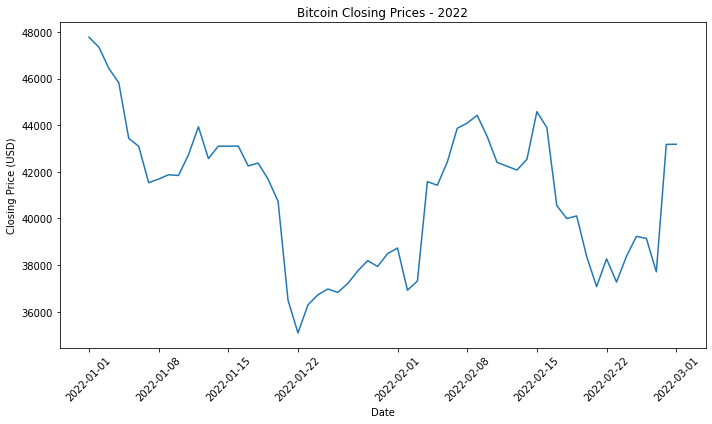

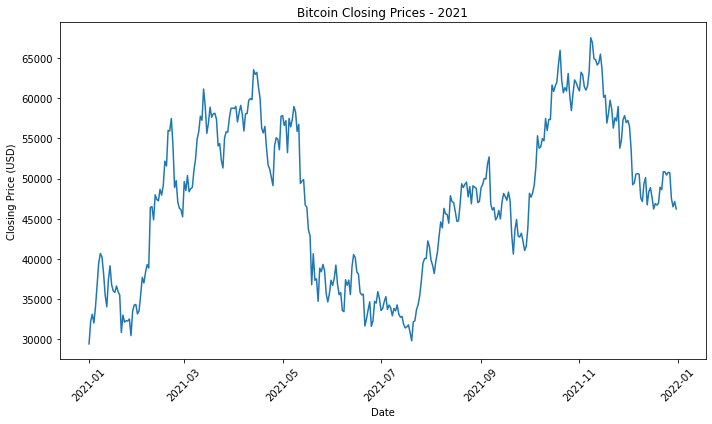

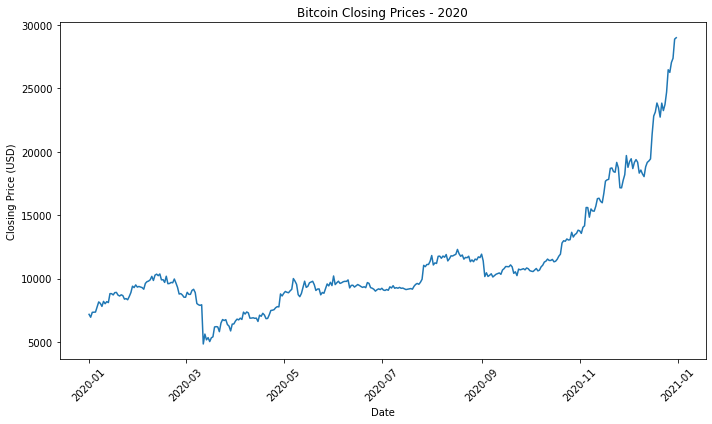

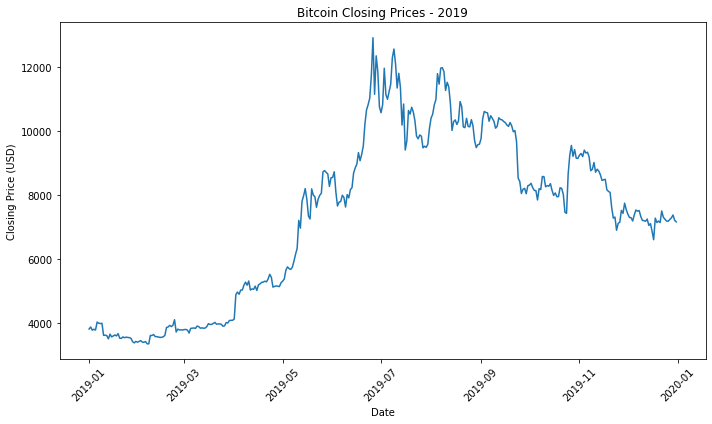

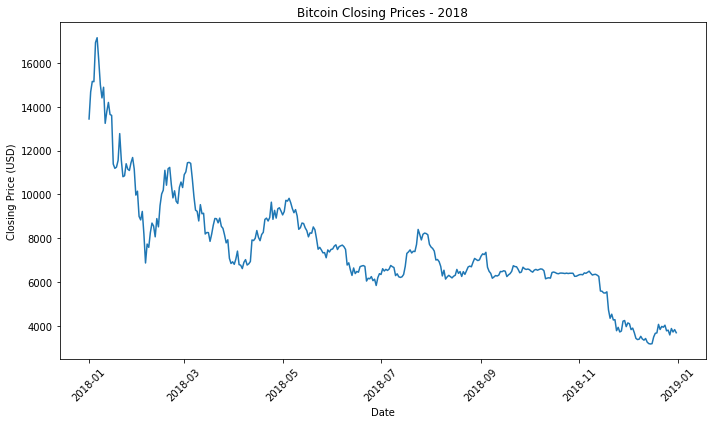

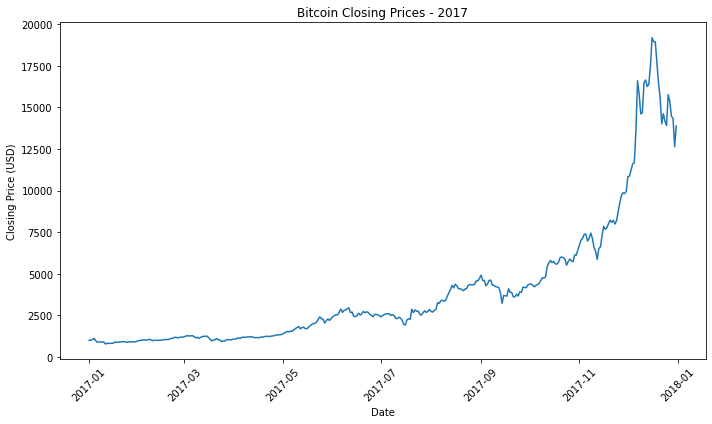

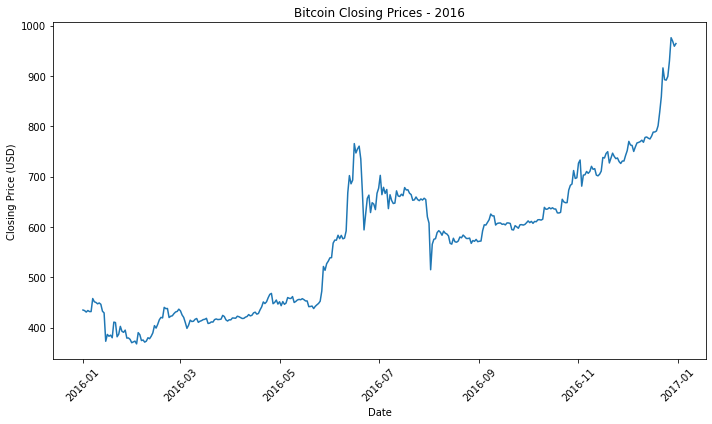

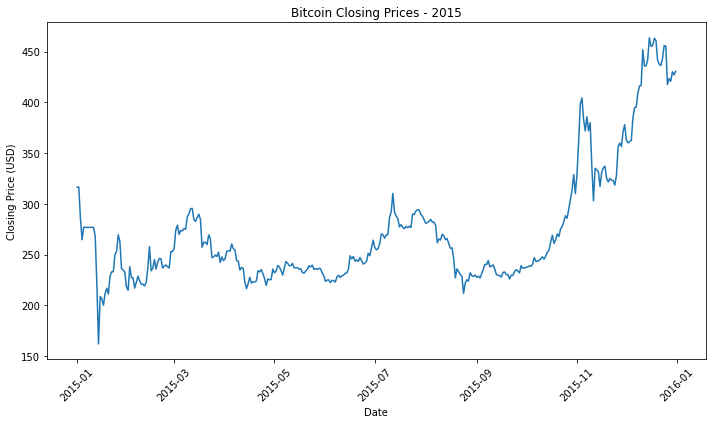

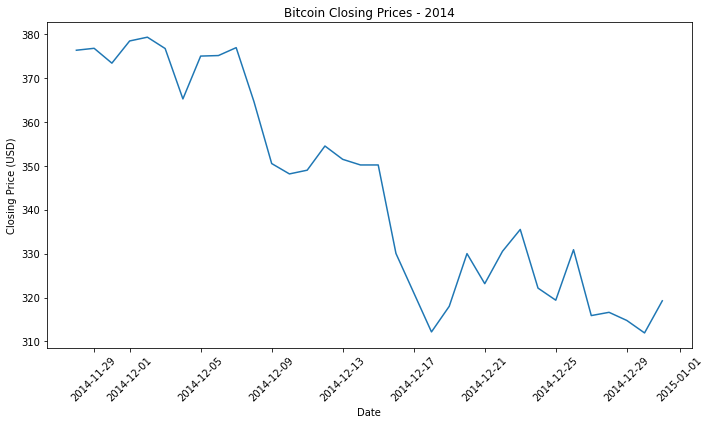

In [15]:
# Range of dates covered
df['date'] = pd.to_datetime(df['date'])
date_range = str(df['date'].dt.date.min()) + ' to ' + str(df['date'].dt.date.max())
print(date_range)

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day


unique_years = df['year'].unique()
for year in unique_years:

    dates = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
    year_month_day = pd.DataFrame({'date': dates})
    year_month_day['year'] = year_month_day['date'].dt.year
    year_month_day['month'] = year_month_day['date'].dt.month
    year_month_day['day'] = year_month_day['date'].dt.day


    merged_data = pd.merge(year_month_day, df, on=['year', 'month', 'day'], how='left')

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(merged_data['date_x'], merged_data['close'])
    plt.title(f'Bitcoin Closing Prices - {year}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_19732\3180020576.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = df_filtered['date'].map(mdates.date2num)


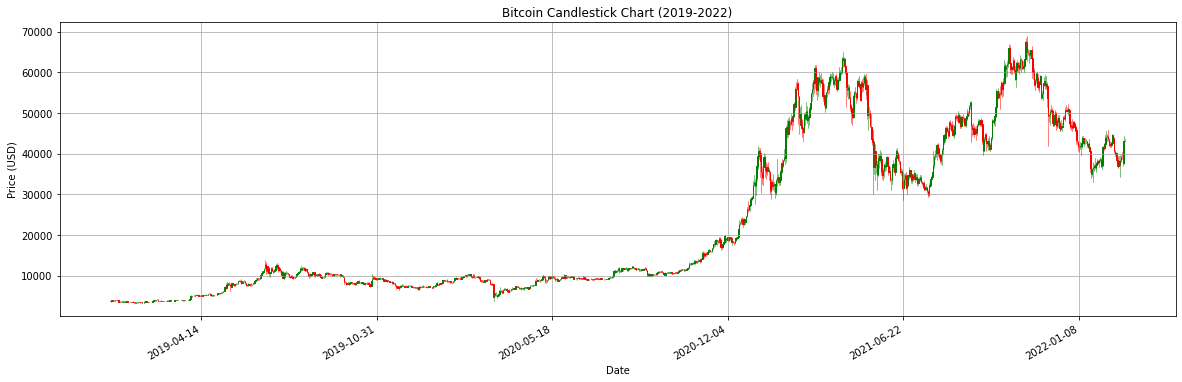

In [19]:
# Filter data for 2019-2022
df_filtered = df[(df['date'] >= '2019-01-01') & (df['date'] <= '2022-12-31')]

# Convert date to matplotlib format
df_filtered['date'] = df_filtered['date'].map(mdates.date2num)

# Create the candlestick chart
fig, ax = plt.subplots(figsize=(20, 6))

candlestick_ohlc(ax, df_filtered[['date', 'open', 'high', 'low', 'close']].values, width=0.6, colorup='g', colordown='r')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

plt.title('Bitcoin Candlestick Chart (2019-2022)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)

# Save the plot as a PDF
plt.savefig('bitcoin_candlestick_2019_2022.pdf')

plt.show()

In [27]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

df["Standardized_Close_Prices"] = scalar.fit_transform(df["close"].values.reshape(-1,1))
df["Standardized_Open_Prices"] = scalar.fit_transform(df["open"].values.reshape(-1,1))
df["Standardized_High_Prices"] = scalar.fit_transform(df["high"].values.reshape(-1,1))
df["Standardized_Low_Prices"] = scalar.fit_transform(df["low"].values.reshape(-1,1))

In [31]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


def predict(X, w, b):
    return X.dot(w) + b

def gradient(y_hat, y, x):
    loss = y_hat-y
    dw = x.T.dot(loss)/len(y)
    db = np.sum(loss)/len(y)
    cost = np.sum(loss**2)/(2*len(y))
    return (dw,db, cost)

def update_weight(w,b,lr,dw,db):
    w_new = w - lr*dw
    b_new = b - lr*db
    return (w_new, b_new)

def linear_regression_vectorized(X, y, learning_rate=0.01, num_iterations=200):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)  # Initialize weights
    b = 0  # Initialize bias
    losses = []

    for _ in range(num_iterations):
        y_hat = predict(X, w, b)  # Make predictions
        dw, db, cost = gradient(y_hat, y, X)  # Calculate gradients
        w, b = update_weight(w, b, learning_rate, dw, db)  # Update weights and bias
        losses.append(cost)
    return w, b, losses


X = df[["Standardized_Open_Prices", "Standardized_High_Prices", "Standardized_Low_Prices"]]
y = df["Standardized_Close_Prices"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

w, b, losses = linear_regression_vectorized(X_train.values, y_train.values, learning_rate=0.01, num_iterations=200)


# Make predictions on the test set
y_pred = predict(X_test, w, b)

# Calculate RMSE
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))

# Calculate MAE
mae = np.mean(np.abs(y_pred - y_test))

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


# Calculate R-squared on training data
y_train_pred = predict(X_train, w, b)
train_accuracy = r2_score(y_train, y_train_pred)

# Calculate R-squared on testing data
test_accuracy = r2_score(y_test, y_pred)

print("Root Mean Square Error (RMSE):", round(rmse, 4))
print("Mean Absolute Error (MAE):", round(mae, 4))
print("Training Accuracy (R-squared):", round(train_accuracy, 4))
print("Testing Accuracy (R-squared):", round(test_accuracy, 4))

Root Mean Square Error (RMSE): 0.0297
Mean Absolute Error (MAE): 0.0138
Training Accuracy (R-squared): 0.9989
Testing Accuracy (R-squared): 0.9991
